In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv("../data/final/healthcare_efficiency_master.csv")

In [2]:
# Calculate provincial averages and efficiency metrics
provincial_stats = df.groupby('province').agg({
    'raw_efficiency': 'mean',
    'avg_wait_time': 'mean',
    'total_spending_per_capita': 'mean'
}).round(1)

# Calculate efficiency gap from best performer
best_efficiency = provincial_stats['raw_efficiency'].max()
provincial_stats['efficiency_gap'] = best_efficiency - provincial_stats['raw_efficiency']

# Create efficiency rankings
provincial_stats['rank'] = provincial_stats['raw_efficiency'].rank(ascending=False).astype(int)
rankings_table = provincial_stats.sort_values('rank')[['rank', 'raw_efficiency', 'avg_wait_time', 'efficiency_gap']]
rankings_table.columns = ['Rank', 'Efficiency_Score', 'Wait_Time_Days', 'Efficiency_Gap']

# Establish efficiency tiers
def efficiency_tier(gap):
    if gap <= 25: return 'High'
    elif gap <= 60: return 'Medium'
    else: return 'Low'

rankings_table['Efficiency_Tier'] = rankings_table['Efficiency_Gap'].apply(efficiency_tier)

print("Provincial Healthcare Efficiency Rankings:")
print(rankings_table)

# Key performance summary
best_province = rankings_table.index[0]
worst_province = rankings_table.index[-1]
performance_range = rankings_table.loc[best_province, 'Efficiency_Score'] - rankings_table.loc[worst_province, 'Efficiency_Score']

Provincial Healthcare Efficiency Rankings:
                           Rank  Efficiency_Score  Wait_Time_Days  \
province                                                            
Ontario                       1             189.8            35.6   
Newfoundland and Labrador     2             189.3            53.5   
Saskatchewan                  3             144.2            60.1   
British Columbia              4             139.9            49.7   
Alberta                       5             138.8            54.8   
New Brunswick                 6             114.0            63.7   
Quebec                        7             110.5            61.9   
Nova Scotia                   8             107.9            74.0   
Manitoba                      9              98.8            75.5   
Prince Edward Island          9              98.8            73.3   

                           Efficiency_Gap Efficiency_Tier  
province                                                   
Ontario 

In [3]:
# Test 1: ANOVA for provincial differences
provinces = df['province'].unique()
efficiency_groups = [df[df['province'] == prov]['raw_efficiency'].dropna().values for prov in provinces]
f_stat, p_anova = stats.f_oneway(*efficiency_groups)

# Test 2: Efficiency-Wait Time correlation
eff_wait_corr, p_wait = stats.pearsonr(df['raw_efficiency'].dropna(), df['avg_wait_time'].dropna())

# Test 3: Efficiency-Spending correlation
eff_spend_corr, p_spend = stats.pearsonr(df['raw_efficiency'].dropna(), df['total_spending_per_capita'].dropna())

# Statistical results summary
stats_results = pd.DataFrame({
    'Test': ['Provincial Differences (ANOVA)', 'Efficiency vs Wait Time', 'Efficiency vs Spending'],
    'Statistic': [f'F={f_stat:.3f}', f'r={eff_wait_corr:.3f}', f'r={eff_spend_corr:.3f}'],
    'P_Value': [f'{p_anova:.6f}', f'{p_wait:.6f}', f'{p_spend:.6f}'],
    'Significant': [p_anova < 0.05, p_wait < 0.05, p_spend < 0.05]
})

print("Statistical Validation Results:")
print(stats_results.to_string(index=False))

Statistical Validation Results:
                          Test Statistic  P_Value  Significant
Provincial Differences (ANOVA)   F=7.087 0.000000         True
       Efficiency vs Wait Time  r=-0.710 0.000000         True
        Efficiency vs Spending   r=0.160 0.037544         True


In [4]:
# Tier performance summary
tier_summary = rankings_table.groupby('Efficiency_Tier').agg({
    'Efficiency_Score': ['count', 'mean'],
    'Efficiency_Gap': 'mean',
    'Wait_Time_Days': 'mean'
}).round(1)
tier_summary.columns = ['Province_Count', 'Avg_Efficiency', 'Avg_Gap', 'Avg_Wait_Time']

print("Provincial Efficiency Tier Analysis:")
print(tier_summary)

Provincial Efficiency Tier Analysis:
                 Province_Count  Avg_Efficiency  Avg_Gap  Avg_Wait_Time
Efficiency_Tier                                                        
High                          2           189.6      0.2           44.6
Low                           5           106.0     83.8           69.7
Medium                        3           141.0     48.8           54.9


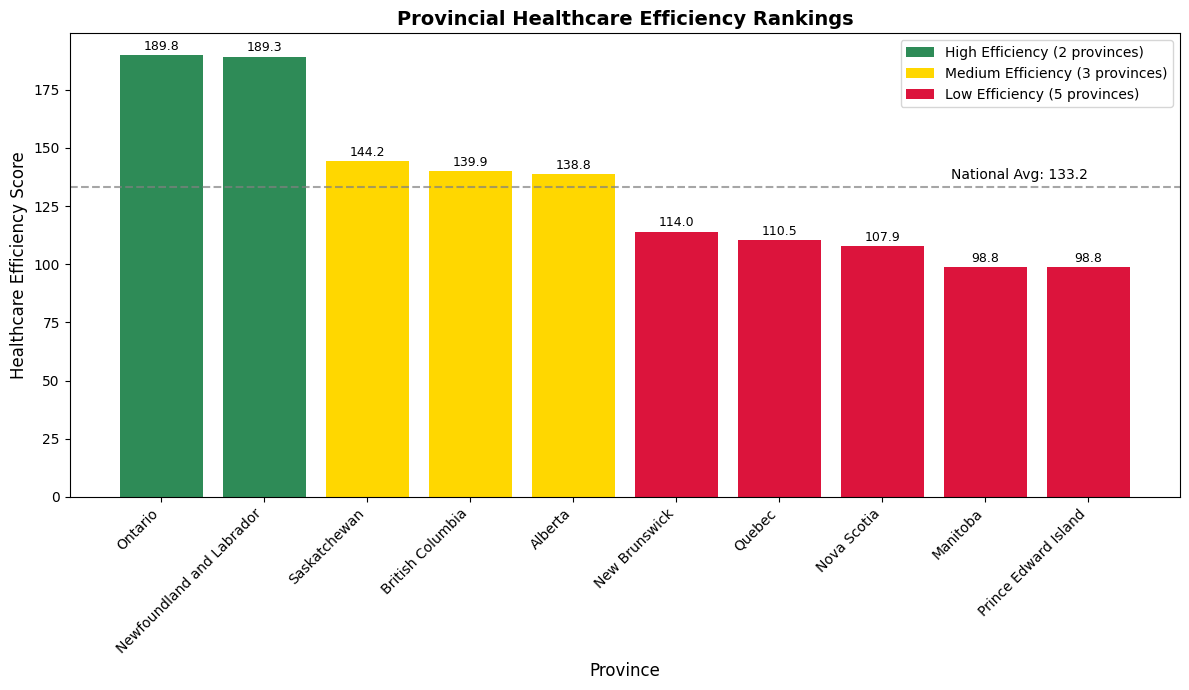

In [5]:
# Tier colors
color_map = {'High': '#2E8B57', 'Medium': '#FFD700', 'Low': '#DC143C'}
colors = [color_map[tier] for tier in rankings_table['Efficiency_Tier']]

# Create efficiency rankings chart
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(range(len(rankings_table)), rankings_table['Efficiency_Score'], color=colors)

# Chart formatting
ax.set_xlabel('Province', fontsize=12)
ax.set_ylabel('Healthcare Efficiency Score', fontsize=12)
ax.set_title('Provincial Healthcare Efficiency Rankings', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(rankings_table)))
ax.set_xticklabels(rankings_table.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Add national average line
national_avg = rankings_table['Efficiency_Score'].mean()
ax.axhline(y=national_avg, color='gray', linestyle='--', alpha=0.7)
ax.text(len(rankings_table)-1, national_avg+2, f'National Avg: {national_avg:.1f}', 
        ha='right', va='bottom', fontsize=10)

# Legend
from matplotlib.patches import Patch
tier_counts = rankings_table['Efficiency_Tier'].value_counts()
legend_elements = [
    Patch(facecolor='#2E8B57', label=f'High Efficiency ({tier_counts.get("High", 0)} provinces)'),
    Patch(facecolor='#FFD700', label=f'Medium Efficiency ({tier_counts.get("Medium", 0)} provinces)'),
    Patch(facecolor='#DC143C', label=f'Low Efficiency ({tier_counts.get("Low", 0)} provinces)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()